In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

### 부동산 매매 실거래 데이터

#### 결측치 처리를 위해 1년전 데이터와 결합

In [2]:
data = pd.read_csv('data/raw_data/apt_trade_data_raw.csv', encoding='cp949')
prev = pd.read_csv('data/raw_data/apt_trade_data_201607_201706.csv', encoding='cp949').iloc[:,2:]
data = pd.concat([data,prev])

#### 해제 거래 및 전용면적 40㎡ 미만 거래 데이터에서 삭제

In [3]:
data = data[data['해제여부'].isna() & (data['전용면적']>=40)]

#### 도로명 주소 및 법정동 주소 컬럼 생성

- 도로명이 결측치일 시 도로명코드를 참조하여 도로명 생성

In [4]:
print(data['도로명'].isna().sum(), data['도로명코드'].isna().sum())

28023 949


In [5]:
code = pd.read_csv('data/raw_data/도로명코드_전체.txt', encoding='cp949', sep='\t')
code = code[code['폐지구분']==0]
code = dict(zip(code['도로명코드'], code['도로명']))
data['도로명'] = data['도로명코드'].apply(lambda x: code.get(int(x)) if x==x else x)

- 법정동코드를 시군구로 변환

In [6]:
code = pd.read_csv('data/raw_data/법정동코드 전체자료.txt', encoding='cp949', sep='\t')
code = code[code['폐지여부']=='존재']
code['법정동코드'] = code['법정동코드'].apply(lambda x: str(x)[:5]).astype(int)
code = code[code['법정동코드'] % 1000 > 0]
code['법정동명'] = code['법정동명'].apply(lambda x: ' '.join(x.split()[:3]))
for s in ['특별', '자치', '직할', '광역']: code['법정동명'] = code['법정동명'].str.replace(s, '')
code = code.drop_duplicates('법정동코드').iloc[:,:-1]

In [7]:
print(data[~data['지역코드'].isin(code['법정동코드'])].shape[0])

0


- 시군구를 다른 열과 조합하여 도로명 주소 및 법정동 주소 생성

In [8]:
data[data['지번'].isna()][['지역코드','아파트']].drop_duplicates()

,지역코드,아파트
104461,11650,힐스테이트 서초 젠트리스


In [9]:
data['지번'].fillna('557', inplace=True)

In [10]:
code = dict(zip(code['법정동코드'], code['법정동명']))

data['도로명주소'] = data['지역코드'].apply(lambda x: code[x]) + \
    data['도로명'].apply(lambda x: ' ' +x if x==x and x else '') + \
    data['도로명건물본번호코드'].apply(lambda x: ' '+str(int(x)) if x==x else '') + \
    data['도로명건물부번호코드'].apply(lambda x: '-'+str(int(x)) if x==x and x else '')

data['법정동주소'] = data['지역코드'].apply(lambda x: code[x]) + \
    data['법정동'].apply(lambda x: ' ' + x if x==x else '') + \
    data['지번'].apply(lambda x: ' '+x if x==x else '')

#### 가격 정수형으로 수정

- 가격 사이에 ,가 들어가 있는 행이 존재 -> 제거

In [11]:
data['거래금액'] = data['거래금액'].apply(lambda x: str(x).replace(',','')).astype(int)

#### 전용면적 구간화
- 60 미만, 75 미만, 85 미만, 103 미만, 103 이상으로 분류

In [12]:
for i in range(4): data[f'temp_{i}'] = data['전용면적'] >= [60, 75, 85, 103][i]
data['전용면적구간'] = data[[f'temp_{i}' for i in range(4)]].sum(axis=1)
data.drop([f'temp_{i}' for i in range(4)], axis=1, inplace=True)

#### 분기 컬럼 생성

In [13]:
data['분기'] = data['년'].astype(str) + ' ' + ((data['월']-1) // 3 + 1).astype(str) + 'Q'

#### 잘못된 행 수정

In [14]:
data = data.reset_index(drop=True)

- 건축년도 결측치: 수작업으로 채우기

In [15]:
data['건축년도'].fillna(2021, inplace=True)

- (아파트, 도로명주소, 법정동주소, 건축년도)가 고유한지 체크
- 도로명 결측치일 시 법정동 주소 활용
- 동일한 도로명 주소에 건축년도가 20년이상 차이날 시 오래된 아파트는 삭제
- 나머지는 같은 아파트단지로 간주, 건축년도는 산술평균 사용 (거래량 반영)

In [16]:
data_addr = data.drop_duplicates(['아파트','도로명주소','법정동주소','건축년도']).reset_index(drop=True)

In [17]:
addr = data_addr['도로명주소'].value_counts()[data_addr['도로명주소'].value_counts()>1].index
data_addr2 = data_addr[data_addr['도로명주소'].isin(addr) & ~data_addr['도로명'].isna()][['아파트','도로명','도로명주소','법정동주소','건축년도']]
table = data_addr2.groupby('도로명주소')['건축년도'].agg(['count','max','min']).reset_index()
table['diff'] = table['max']-table['min']
addr_del = table[table['diff']>=20]['도로명주소']
to_del = data[data['도로명주소'].isin(addr_del) & (data['건축년도']<2000)].index
data = data.drop(to_del).reset_index(drop=True)

In [18]:
addr = data_addr['도로명주소'].value_counts()[data_addr['도로명주소'].value_counts()>1].index
data_addr2 = data_addr[data_addr['도로명주소'].isin(addr) & ~data_addr['도로명'].isna()][['아파트','도로명','도로명주소','법정동주소','건축년도']]
table = data_addr2.groupby('도로명주소')['건축년도'].agg(['count','max','min']).reset_index()
table['diff'] = table['max']-table['min']
addr_del = table[table['diff']>=20]['도로명주소']
to_del = data[data['도로명주소'].isin(addr_del) & (data['건축년도']<2000)].index
data = data.drop(to_del).reset_index(drop=True)
table2 = data[data['도로명주소'].isin(table[(table['diff']>0)&(table['diff']<20)]['도로명주소']) & ~data['도로명'].isna()].groupby(['도로명주소'])['건축년도'].agg('mean').reset_index()
table2['건축년도'] = table2['건축년도'].apply(np.round)
data = data.merge(table2,on='도로명주소',how='left')
data['건축년도_y'] = data['건축년도_y'].fillna(data['건축년도_x'])
data = data.drop('건축년도_x', axis=1).rename({'건축년도_y':'건축년도'},axis=1)

- 법정동 주소가 동일한 아파트도 동일한 방식으로 처리

In [19]:
addr = data_addr['법정동주소'].value_counts()[data_addr['법정동주소'].value_counts()>1].index
data_addr2 = data_addr[data_addr['법정동주소'].isin(addr)][['아파트','도로명주소','법정동주소','건축년도']]
table = data_addr2.groupby('법정동주소')['건축년도'].agg(['count','max','min']).reset_index()
table['diff'] = table['max']-table['min']
addr_del = table[table['diff']>=20]['법정동주소']
to_del = data[data['법정동주소'].isin(addr_del) & (data['건축년도']<2000)].index
data = data.drop(to_del).reset_index(drop=True)
table2 = data[data['법정동주소'].isin(table[(table['diff']>0)&(table['diff']<20)]['법정동주소'])].groupby(['법정동주소'])['건축년도'].agg('mean').reset_index()
table2['건축년도'] = table2['건축년도'].apply(np.round)
data = data.merge(table2,on='법정동주소',how='left')
data['건축년도_y'] = data['건축년도_y'].fillna(data['건축년도_x'])
data = data.drop('건축년도_x', axis=1).rename({'건축년도_y':'건축년도'},axis=1)

#### 필요한 컬럼만 남기고 나머지 삭제

In [20]:
data = data[['도로명', '도로명주소', '법정동주소', '건축년도', '전용면적', '거래금액', '전용면적구간', '분기']]

#### 그룹화

- (도로명주소, 면적구간, 분기)로 그룹화
- 도로명이 결측치일 시 법정동 주소를 사용

In [21]:
idx = data[data['도로명'].isna()].index
data.loc[idx,'도로명주소']=data.loc[idx,'법정동주소']
data.drop(['도로명','법정동주소'], axis=1, inplace=True)

In [22]:
tmp = data[['도로명주소','건축년도']].drop_duplicates().groupby('도로명주소').agg('std').reset_index()
tmp[tmp['건축년도']>0]

,도로명주소,건축년도
10035,경상남도 밀양시 중앙로 238-8,1.414214


In [23]:
y=data[data['도로명주소']=='경상남도 밀양시 중앙로 238-8']['건축년도'].mean().round()
idx = data[data['도로명주소']=='경상남도 밀양시 중앙로 238-8'].index
data.loc[idx,'건축년도'] = y

In [24]:
data = data.groupby(['도로명주소','전용면적구간','분기']).agg(['sum','count']).reset_index()
data.columns = ['도로명주소', '전용면적구간', '분기', '건축년도', '', '전용면적합', '', '거래금액합', '거래량']
data = data[[i for i in data.columns if i]]
data['건축년도'] = data['건축년도'] // data['거래량'] 
data['단위면적당거래금액'] = data['거래금액합'] / data['전용면적합']
data['평균거래금액'] = data['거래금액합'] / data['거래량']

#### 거래금액 결측치 처리

- 결측치일 시 가장 마지막 거래를 기준
- 결측치가 일정 수준 이상일 시 삭제 고려

In [25]:
table = data[['도로명주소', '전용면적구간', '건축년도']].drop_duplicates().reset_index(drop=True)
table = pd.DataFrame(map(lambda x: np.repeat(table[x].to_numpy(),29), table.columns), index=table.columns).T
table['분기'] = np.tile([f'{2016+i//4} {i%4+1}Q' for i in range(32)][2:-1], table.shape[0]//29)
data = table.merge(data, on=['도로명주소','전용면적구간', '분기', '건축년도'], how='left')

In [26]:
data.isna().sum()

도로명주소              0
전용면적구간             0
건축년도               0
분기                 0
전용면적합        1154553
거래금액합        1154553
거래량          1154553
단위면적당거래금액    1154553
평균거래금액       1154553
dtype: int64

In [27]:
data['거래량'].fillna(0, inplace=True)
data.loc[::29,:].fillna(0, inplace=True)
data.fillna(method='ffill', inplace=True)
data['거래존재여부'] = data['거래량']>0
data=data[data['분기']>='2017 3Q']

In [28]:
data.to_csv('data/apt_trade_data.csv', encoding='cp949', index=False)

In [29]:
import seaborn as sns

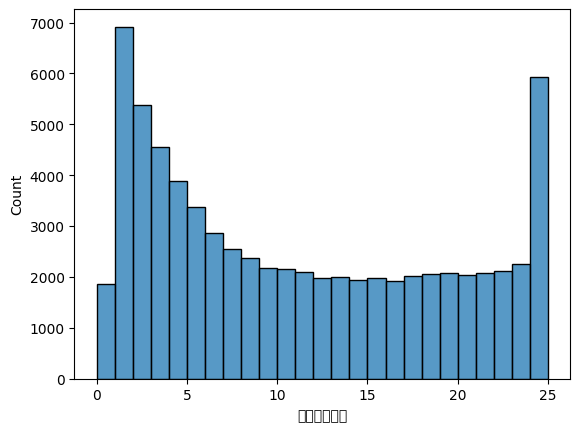

In [30]:
table = data.groupby(['도로명주소', '전용면적구간'])[['거래존재여부']].agg('sum').reset_index()
sns.histplot(table['거래존재여부'], binwidth=1);